In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os; print(os.getcwd())
import socket; print(socket.gethostname())

/home/ajasja/projects/truncator
dig2


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from glob import glob
import truncator



In [3]:
#import sys; sys.path.insert(0, "/home/ajasja/projects/Stable_Heterodimers")
#import utils as u

In [4]:
picks = truncator.read_file_lines("out/R3/For_surface.picks", skip_comments=True)
for pick_name in picks:
    print('delete all')
    print(f"load '{pick_name}'")
    print('select loops, ss l')
    print('color red, loops')
    print("")

delete all
load 'out/R3/11_relooped/ZCON_127/ZCON_127__numH4.5__from-20.77__to21.47__ccC-DAB__llr2,4__ar1-2,0__ar2-3,0__rms0.5/ZCON_127__numH4.5__from-20.77__to21.47__ccC-DAB__llr2,4__ar1-2,0__ar2-3,0__rms0.5.pdb'
select loops, ss l
color red, loops

delete all
load 'out/R3/11_relooped/ZCON_127/ZCON_127__numH4.5__from-20.77__to21.47__ccDA-BC__llr2,5__ar1-3,0__ar2-3,0__rms0.5/ZCON_127__numH4.5__from-20.77__to21.47__ccDA-BC__llr2,5__ar1-3,0__ar2-3,0__rms0.5.pdb'
select loops, ss l
color red, loops

delete all
load 'out/R3/11_relooped/ZCON_15_re_loop/ZCON_15_re_loop__numH4.5__from-6.83__to32.93__ccC-BAD__llr2,5__ar1-2,0__ar2-1,0__rms0.5/ZCON_15_re_loop__numH4.5__from-6.83__to32.93__ccC-BAD__llr2,5__ar1-2,0__ar2-1,0__rms0.5.pdb'
select loops, ss l
color red, loops

delete all
load 'out/R3/11_relooped/ZCON_15_re_loop/ZCON_15_re_loop__numH4.5__from-6.83__to32.93__ccAD-CB__llr2,5__ar1-2,0__ar2-1,0__rms0.5/ZCON_15_re_loop__numH4.5__from-6.83__to32.93__ccAD-CB__llr2,5__ar1-2,0__ar2-1,0__rms0.5.

In [9]:
%%time
struct_name = picks[5]
result=truncator.fix_surface(struct_name, out_dir='out/R3/23_fix_surf/prob_low', script_name='truncator/xml/31_fix_surf.xml', 
                                                  rosetta_bin="/software/rosetta/latest/bin/rosetta_scripts",);

print(result.score_file)


cd out/R3/23_fix_surf/prob_low/ZCON_13__numH4.5__from-17.52__to22.91__ccBC-DA__llr2,5__ar1-1,0__ar2-1,0__rms0.5__ch-5; /software/rosetta/latest/bin/rosetta_scripts  \
-parser:protocol /home/ajasja/projects/truncator/truncator/xml/31_fix_surf.xml \
-s /home/ajasja/projects/truncator/out/R3/11_relooped/ZCON_13/ZCON_13__numH4.5__from-17.52__to22.91__ccBC-DA__llr2,5__ar1-1,0__ar2-1,0__rms0.5/ZCON_13__numH4.5__from-17.52__to22.91__ccBC-DA__llr2,5__ar1-1,0__ar2-1,0__rms0.5.pdb \
-out:suffix __ch-5 \
-out:file:scorefile  ZCON_13__numH4.5__from-17.52__to22.91__ccBC-DA__llr2,5__ar1-1,0__ar2-1,0__rms0.5__ch-5.sc \
-beta \
-in:file:fullatom \
-renumber_pdb 1 \
-out:file:pdb_comments true \
-run:preserve_header true \
-out:file:scorefile_format json \
-out:pdb \
-out:no_nstruct_label \
-chemical:exclude_patches LowerDNA  UpperDNA Cterm_amidation VirtualBB ShoveBB VirtualDNAPhosphate VirtualNTerm CTermConnect sc_orbitals pro_hydroxylated_case1 pro_hydroxylated_case2 ser_phosphorylated thr_phosphory

In [5]:
import dask, distributed
client = distributed.Client(scheduler_file='scheduler.json'); client

Client Scheduler: tcp://172.16.131.32:21675 Dashboard: http://172.16.131.32:8787/status,Cluster Workers: 1 Cores: 1 Memory: 2.00 GB


In [6]:

res = []
for struct_name in picks:
    res.append(client.submit(
        truncator.fix_surface,struct_name, out_dir='out/R3/23_fix_surf', script_name='truncator/xml/31_fix_surf.xml', 
                                                  rosetta_bin="/software/rosetta/latest/bin/rosetta_scripts")
                 );



distributed.wait(res, timeout=1);

TimeoutError: Timeout

In [7]:
distributed.wait(res, timeout=1);

TimeoutError: Timeout

In [8]:
#print("\n".join(list(df.columns)));
cols = truncator.read_file_lines('col_order.list', skip_comments=True)
df = df[cols]


In [9]:
len(df)

6129

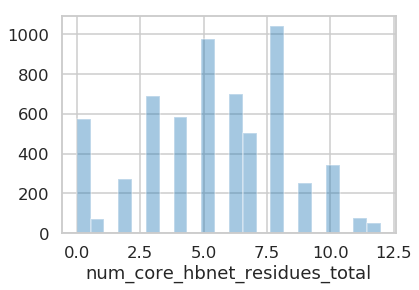

In [16]:

sns.distplot(df['num_core_hbnet_residues_total'].dropna(), kde=False)


In [7]:
logs = sorted(glob("out/01_fuse_to_3chain_14o_7r//*/*/*.sc"))
logs;

In [8]:
%%time
scores = u.load_score_files(logs, load_seq=True)

CPU times: user 1.78 s, sys: 56.4 ms, total: 1.83 s
Wall time: 2.09 s


In [36]:
scores.set_index('description', inplace=True, drop=False)

In [9]:
scores["n_aa"] = scores["seq"].str.len()

KeyError: 'seq'

In [14]:
scores["fa_rep_per_aa"] = scores["fa_rep"]/scores["n_aa"]

In [39]:
scores.to_csv("out/01_fuse_to_3chain_14o_7r.scores")

In [75]:
pd.set_option('display.max_colwidth', -1)
q =scores.sort_values(by='fa_rep').query('fa_rep<400 and sc2>0.5')
print(len(q))
chosen = q
q['total_score fa_rep fa_rep_per_aa clash_check_soft clash_check_hard longest_hpc uhb sc1 sc2 sc1_int_area sc2_int_area full_name'.split()][:10

43


In [76]:
chosen.columns

Index(['total_score', 'ala_count', 'clash_check_hard', 'clash_check_soft',
       'dslf_fa13', 'fa_atr', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi',
       'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec',
       'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_rep_fitler',
       'fa_sol', 'gen_bonded', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc',
       'hbond_sr_bb', 'hxl_tors', 'lk_ball', 'lk_ball_bridge',
       'lk_ball_bridge_uncpl', 'lk_ball_iso', 'longest_hpc', 'omega',
       'p_aa_pp', 'pro_close', 'rama_prepro', 'ref', 'sc1', 'sc1_int_area',
       'sc2', 'sc2_int_area', 'ss_count', 'uhb', 'full_name', 'seq', 'n_aa',
       'fa_rep_per_aa', 'description'],
      dtype='object')

In [77]:
import os
def row_to_worms_dict(row):
    d = {}
    d['file'] = os.path.abspath(row.full_name)
    d['name'] = row.description
    d['class'] = ["Het"]
    d['type'] = ["AL_het_C2_N_C"]
    d['base'] = "ZCON37" 
    d['components'] = ["ZCON37", "DHR1", "DHR2"]
    d['validated'] = False
    d['protocol'] =  "Made by Ajasja with H-fuse"
    d['connections'] = [
        {"chain": 1, "direction": "N", "residues":["1:50"]},
        {"chain": 2, "direction": "C", "residues":["-50:"]}
    ]
    return d


In [84]:
def dataframe_to_worms_database(df, out_file=None):
    res = []
    for row in df.itertuples():
        res.append(row_to_worms_dict(row))
    import json
    if out_file is None:
        return json.dumps(res, indent=4)
    with open(out_file, "w") as write_file:
        json.dump(res, write_file, indent=2)
        
dataframe_to_worms_database(chosen, "ALSD01_2018-11-07.database")      

In [45]:

df = pd.DataFrame({'a': np.random.randn(1000), 'b': np.random.randn(1000),'N': np.random.randint(100, 1000, (1000)), 'x': 'x'})

%timeit [row.a * 2 for idx, row in df.iterrows()]
# => 10 loops, best of 3: 50.3 ms per loop

%timeit [row.a * 2 for row in df.itertuples()]
# => 1000 loops, best of 3: 541 µs per loop

188 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.98 ms ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
188/2.98

63.08724832214765